# GAN-70-Lines-of-Julia  
This notebook is a demonstration for a simple GAN training on MNIST by using Julia. It will highlight how one can program a machine learning model in Julia as if just writing a paper. Let's get started!

## Setup
We will use the deep learning package Knet.jl to compute gradients for the networks and use GPU arrays if a gpu device is available.

In [58]:
using Pkg; for p in ("Knet","Colors","Images"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet, Colors, Images, Statistics
include(Pkg.dir("Knet","data","mnist.jl")) #MNIST data loader functions
global atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}

┌ Warning: `Pkg.dir(pkgname, paths...)` is deprecated; instead, do `import Knet; joinpath(dirname(pathof(Knet)), "..", paths...)`.
└ @ Pkg.API /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Pkg/src/API.jl:454


Array{Float32,N} where N

## MLP Model  
Both for Generator and Discriminator, generic multilayer perceptrons are needed. $\mathbf{w}$ is an array that keeps the model paramaters and $\mathbf{x}$ is the input. Keyword argument $\mathbf{p}$ is the dropout probability, `activation` is the activation function used in the hidden layers, and `outputactivation` is the activation function used in the output layer. We also define `elu` activation function.

In [59]:
function mlp(w,x;p=0.0,activation=elu,outputactivation=sigm)
    for i=1:2:length(w)
        x = w[i]*dropout(mat(x),p) .+ w[i+1] # mat() used for flattening images to a vector.
        i<length(w)-1 && (x = activation.(x)) 
    end
    return outputactivation.(x) #output layer
end

mlp (generic function with 1 method)

## Discriminator and Generator Networks

Discriminator and Generator networks are defined as `D` and `G` respectively. Loss functions `𝑱d` and `𝑱g` are defined according to the equation X in GAN paper. Sample noise function `𝒩` is a normal distribution. Loss functions are defined according to the equations in Algorithm 1 section of the [paper](https://arxiv.org/abs/1406.2661 "arXiv"). We use a slightly modified generator loss according to [GAN tricks](https://github.com/soumith/ganhacks#2-a-modified-loss-function "GAN Tricks").
$$ J_d = -\frac{1}{m} \sum_{i=1}^{m} log(D(x^{(i)}) + log(1-D(G(z^{(i)})))$$
$$ J_g = -\frac{1}{m} \sum_{i=1}^{m} log(D(G(z^{(i)}))) $$ 

*`𝜀` is used to prevent log functions from resulting NaN values.


In [66]:
global const 𝜀=Float32(1e-8)
D(w,x;p=0.0) = mlp(w,x;p=p)
G(w,z;p=0.0) = mlp(w,z;p=p) 
𝑱d(𝗪d,x,Gz) = -mean(log.(D(𝗪d,x) .+ 𝜀)+log.((1+𝜀) .- D(𝗪d,Gz)))/2   
𝑱g(𝗪g, 𝗪d, z) = -mean(log.(D(𝗪d,G(𝗪g,z)) .+ 𝜀))           
𝒩(input, batch) = atype(randn(Float32, input, batch))  #SampleNoise

𝒩 (generic function with 1 method)

## Gradient Functions

For backpropogation, we need the derivatives of loss functions according to the model parameters. This is where Knet comes to the scene. The `Knet.grad` function calculates gradient according to the first parameter of any function. So,

In [67]:
∇d  = grad(𝑱d) # Discriminator gradient
∇g  = grad(𝑱g) # Generator gradient

(::getfield(AutoGrad, Symbol("#gradfun#6")){getfield(AutoGrad, Symbol("##gradfun#4#5")){typeof(𝑱g),Int64,Bool}}) (generic function with 1 method)

## Parameter Initialization
It is a generic weight initialization function for MLPs. For each layer, it creates a weight matrix and bias vector, then add them to $W$. 

In [68]:
function initweights(hidden,input, output)
    𝗪 = Any[];
    x = input
    for h in [hidden... output]
        push!(𝗪, atype(xavier(h,x)), atype(zeros(h, 1))) #FC Layers weights and bias
        x = h
    end
    return 𝗪  #return model params
end

initweights (generic function with 1 method)

## Generate and Display

This function generates a random `number` of images and displays them.

In [69]:
function generate_and_show(𝗪,number,𝞗)
    Gz    = Array(G(𝗪[1], 𝒩(𝞗[:ginp], number))) .> 0.5
    Gz    = reshape(Gz, (28, 28, number))
    L     = floor(Int, sqrt(number))
    grid  = []
    for i = 1:L:number
        push!(grid, reshape(permutedims(Gz[:,:,i:i+L-1], (2,3,1)), (L*28,28)))
    end
    display(Gray.(hcat(grid...)))
end

generate_and_show (generic function with 1 method)

## Train & Test Function

This `runmodel` function is implementing training procedure described in GAN paper. It first update discriminator with specified optimizer, then update generator network. Same function can be used in test mode by passing `train` argument as false. In the test mode it calculates losses instead of gradients.

In [70]:
function runmodel(𝗪, data, 𝞗; dtst=nothing, optim=nothing, train=false, saveinterval=20)
    gloss = dloss = total=0.0;
    B = 𝞗[:batchsize]
    for i=1:(train ? 𝞗[:epochs] : 1)
        for (x,_) in data
            total+=2B
            Gz = G(𝗪[1], 𝒩(𝞗[:ginp], B)) #Generate Fake Images
            train ? update!(𝗪[2], ∇d(𝗪[2],x,Gz), optim[2]) : (dloss += 2B*𝑱d(𝗪[2], x, Gz))
            
            z=𝒩(𝞗[:ginp],2B) #Sample z from Noise
            train ? update!(𝗪[1], ∇g(𝗪[1], 𝗪[2], z), optim[1]) : (gloss += 2B*𝑱g(𝗪[1],𝗪[2],z))       
        end
        train ? runmodel(𝗪, dtst, 𝞗; train=false) : println((gloss/total, dloss/total))
        i % saveinterval == 0 && generate_and_show(𝗪, 100, 𝞗)  # save 10 images
    end
end

runmodel (generic function with 1 method)

## Run
We will train our model 80 epochs and display resulted images in each 20 epoch. The log format here is (generator loss, discriminator loss).

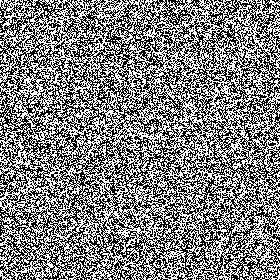

(0.964181468463861, 0.6261569328415089)
(2.8460408051808677, 0.10484407961559601)
(2.720964103172987, 0.36418946178104633)


InterruptException: InterruptException:

In [71]:
𝞗=Dict(:batchsize=>32,:epochs=>80,:ginp=>256,:genh=>[512],:disch=>[512],:optim=>Adam,:lr=>0.0002);
xtrn,ytrn,xtst,ytst = mnist()
global dtrn = minibatch(xtrn, ytrn, 𝞗[:batchsize]; xtype=atype)
global dtst = minibatch(xtst, ytst, 𝞗[:batchsize]; xtype=atype)
𝗪  = (𝗪g,𝗪d)  = initweights(𝞗[:genh], 𝞗[:ginp], 784), initweights(𝞗[:disch], 784, 1)
𝚶  = (𝚶pg,𝚶pd) = optimizers(𝗪g, 𝞗[:optim]; lr=𝞗[:lr]), optimizers(𝗪d,𝞗[:optim]; lr=𝞗[:lr])
generate_and_show(𝗪,100,𝞗)
runmodel(𝗪, dtst, 𝞗; optim=𝚶, train=false) # initial losses
runmodel(𝗪, dtrn, 𝞗; optim=𝚶, train=true, dtst=dtst) # training  